# Section 4b: Gpu Power and Temperature Analysis

In [1]:
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [4]:
df_prom = spark.read.parquet(path_node_dataset)
df_prom.show(5, False)

24/05/03 22:16:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------+-------------------+-----+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+------------------------

In [5]:
df_node_hardware_info = spark.read.parquet(path_node_hardware_info)
df_node_hardware_info.show(5, False)

+------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+--------------------------------+---------+-------------------------+----------------+------------+---------+----------------------+-------------+
|node  |cpu_model|cpu_core_count_per_socket|cpu_threads_per_core|cpu_tdp_per_socket|cpu_t_case_max|cpu_per_core_temp_max|cpu_count|cpu_core_count_total|cpu_memory_bytes_total|cpu_tdp_total|node_filesystem_size_bytes_total|gpu_model|gpu_memory_bytes_per_card|gpu_tdp_per_card|gpu_temp_max|gpu_count|gpu_memory_bytes_total|gpu_tdp_total|
+------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+--------------------------------+---------+-------------------------+----------------+------------+---------+----------------------+-------

In [6]:
nvidia_cols = [c for c in df_prom.columns if 'nvidia' in c]

df_prom_selected = df_prom.select(['node', 'timestamp', 'node_ambient_temp'] + nvidia_cols + ['gpu_node'])
df_prom_node_data_extended = df_prom_selected.join(df_node_hardware_info, how='left', on='node')

df_prom_node_data_extended.show(5, False)

print(df_prom_node_data_extended.count())
print(df_prom_node_data_extended.dropna().count())

+-----+-------------------+-----------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+----------------------------------+-----------------------------------+----------------------------------+-------------------------------+--------------------------------+-------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------------------------------+-------------------------------------+--------------------------------------+-------------------------------------+-------------------------+--------------------------+-------------------------+--------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+---------------------

127827719


127827719


In [7]:
nvidia_cols = [c for c in df_prom_node_data_extended.columns if 'nvidia' in c]
print(nvidia_cols)

# use one nvida attribute to get the number of gpu slots
new_nvidia_cols = nvidia_cols[nvidia_cols.index('nvidia_gpu_temperature_celsius_0'):]
print(new_nvidia_cols)


gpu_slots = list(set([c.split('_')[-1] for c in new_nvidia_cols]))
gpu_slots = [int(g) for g in gpu_slots if g.isnumeric()]
gpu_slots.sort()
print("GPU slots:", gpu_slots)

['nvidia_gpu_memory_used_bytes_sum', 'nvidia_gpu_temperature_celsius_0', 'nvidia_gpu_temperature_celsius_1', 'nvidia_gpu_temperature_celsius_2', 'nvidia_gpu_temperature_celsius_3', 'nvidia_gpu_temperature_celsius_min', 'nvidia_gpu_temperature_celsius_mean', 'nvidia_gpu_temperature_celsius_max', 'nvidia_gpu_fanspeed_percent_min', 'nvidia_gpu_fanspeed_percent_mean', 'nvidia_gpu_fanspeed_percent_max', 'nvidia_gpu_power_usage_milliwatts_0', 'nvidia_gpu_power_usage_milliwatts_1', 'nvidia_gpu_power_usage_milliwatts_2', 'nvidia_gpu_power_usage_milliwatts_3', 'nvidia_gpu_power_usage_milliwatts_min', 'nvidia_gpu_power_usage_milliwatts_sum', 'nvidia_gpu_power_usage_milliwatts_mean', 'nvidia_gpu_power_usage_milliwatts_max', 'nvidia_gpu_duty_cycle_min', 'nvidia_gpu_duty_cycle_mean', 'nvidia_gpu_duty_cycle_max']
['nvidia_gpu_temperature_celsius_0', 'nvidia_gpu_temperature_celsius_1', 'nvidia_gpu_temperature_celsius_2', 'nvidia_gpu_temperature_celsius_3', 'nvidia_gpu_temperature_celsius_min', 'nvidi

In [8]:
df_prom_node_data_extended.show(5, False)

+-----+-------------------+-----------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+----------------------------------+-----------------------------------+----------------------------------+-------------------------------+--------------------------------+-------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------------------------------+-------------------------------------+--------------------------------------+-------------------------------------+-------------------------+--------------------------+-------------------------+--------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+---------------------

In [9]:
df_prom_node_data_extended_2 = df_prom_node_data_extended.select("*")

for gpu_slot in gpu_slots:
    df_prom_node_data_extended_2 = df_prom_node_data_extended_2.withColumn(f'nvidia_gpu_power_usage_milliwatts_{gpu_slot}_ratio', col(f'nvidia_gpu_power_usage_milliwatts_{gpu_slot}') / 1000 / col('gpu_tdp_per_card'))
    df_prom_node_data_extended_2 = df_prom_node_data_extended_2.withColumn(f'nvidia_gpu_temperature_celsius_{gpu_slot}_ratio', (col(f'nvidia_gpu_temperature_celsius_{gpu_slot}') - col('node_ambient_temp')) / (col('gpu_temp_max') - col('node_ambient_temp')))

df_prom_node_data_extended_2.show(5, False)

+-----+-------------------+-----------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+----------------------------------+-----------------------------------+----------------------------------+-------------------------------+--------------------------------+-------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-------------------------------------+-------------------------------------+--------------------------------------+-------------------------------------+-------------------------+--------------------------+-------------------------+--------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+---------------------

In [10]:
df_prom_node_data_extended_3 = df_prom_node_data_extended_2.filter((col('gpu_node') == 1))
df_prom_node_data_extended_3 = df_prom_node_data_extended_3.filter(col('gpu_count') >= 4)

nvidia_cols = [c for c in df_prom_node_data_extended_2.columns if ('nvidia' in c and ('power' in c or 'temperature' in c) and 'ratio' in c) or 'gpu_count' in c]
nvidia_cols.sort()
print(nvidia_cols)

cols = ['node', 'timestamp'] + nvidia_cols
df_prom_node_data_extended_3 = df_prom_node_data_extended_3.select(cols)
df_prom_node_data_extended_3.show(5, False)

['gpu_count', 'nvidia_gpu_power_usage_milliwatts_0_ratio', 'nvidia_gpu_power_usage_milliwatts_1_ratio', 'nvidia_gpu_power_usage_milliwatts_2_ratio', 'nvidia_gpu_power_usage_milliwatts_3_ratio', 'nvidia_gpu_temperature_celsius_0_ratio', 'nvidia_gpu_temperature_celsius_1_ratio', 'nvidia_gpu_temperature_celsius_2_ratio', 'nvidia_gpu_temperature_celsius_3_ratio']
+-----+-------------------+---------+-----------------------------------------+-----------------------------------------+-----------------------------------------+-----------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+
|node |timestamp          |gpu_count|nvidia_gpu_power_usage_milliwatts_0_ratio|nvidia_gpu_power_usage_milliwatts_1_ratio|nvidia_gpu_power_usage_milliwatts_2_ratio|nvidia_gpu_power_usage_milliwatts_3_ratio|nvidia_gpu_temperature_celsius_0_ratio|nvidia_gpu_temperature_celsius_1

In [11]:
df_prom_node_data_extended_3.show(5, True)
# get the mean nvidia_gpu_power_usage_milliwatts_0_ratio for each gpu index
df_prom_node_data_extended_4 = df_prom_node_data_extended_3.groupBy('gpu_count').agg(
    F.mean('nvidia_gpu_power_usage_milliwatts_0_ratio').alias('nvidia_gpu_power_usage_milliwatts_0_ratio_mean'),
    F.mean('nvidia_gpu_power_usage_milliwatts_1_ratio').alias('nvidia_gpu_power_usage_milliwatts_1_ratio_mean'),
    F.mean('nvidia_gpu_power_usage_milliwatts_2_ratio').alias('nvidia_gpu_power_usage_milliwatts_2_ratio_mean'),
    F.mean('nvidia_gpu_power_usage_milliwatts_3_ratio').alias('nvidia_gpu_power_usage_milliwatts_3_ratio_mean')
).show(5, False)
# also std
df_prom_node_data_extended_4 = df_prom_node_data_extended_3.groupBy('gpu_count').agg(
    F.stddev('nvidia_gpu_power_usage_milliwatts_0_ratio').alias('nvidia_gpu_power_usage_milliwatts_0_ratio_std'),
    F.stddev('nvidia_gpu_power_usage_milliwatts_1_ratio').alias('nvidia_gpu_power_usage_milliwatts_1_ratio_std'),
    F.stddev('nvidia_gpu_power_usage_milliwatts_2_ratio').alias('nvidia_gpu_power_usage_milliwatts_2_ratio_std'),
    F.stddev('nvidia_gpu_power_usage_milliwatts_3_ratio').alias('nvidia_gpu_power_usage_milliwatts_3_ratio_std')
).show(5, False)

+-----+-------------------+---------+-----------------------------------------+-----------------------------------------+-----------------------------------------+-----------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+
| node|          timestamp|gpu_count|nvidia_gpu_power_usage_milliwatts_0_ratio|nvidia_gpu_power_usage_milliwatts_1_ratio|nvidia_gpu_power_usage_milliwatts_2_ratio|nvidia_gpu_power_usage_milliwatts_3_ratio|nvidia_gpu_temperature_celsius_0_ratio|nvidia_gpu_temperature_celsius_1_ratio|nvidia_gpu_temperature_celsius_2_ratio|nvidia_gpu_temperature_celsius_3_ratio|
+-----+-------------------+---------+-----------------------------------------+-----------------------------------------+-----------------------------------------+-----------------------------------------+--------------------------------------+--------------------------------

+---------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+
|gpu_count|nvidia_gpu_power_usage_milliwatts_0_ratio_mean|nvidia_gpu_power_usage_milliwatts_1_ratio_mean|nvidia_gpu_power_usage_milliwatts_2_ratio_mean|nvidia_gpu_power_usage_milliwatts_3_ratio_mean|
+---------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+
|4        |0.3427407900925355                            |0.2506042358368223                            |0.28018953221194876                           |0.2342863832897497                            |
+---------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+


+---------+---------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|gpu_count|nvidia_gpu_power_usage_milliwatts_0_ratio_std|nvidia_gpu_power_usage_milliwatts_1_ratio_std|nvidia_gpu_power_usage_milliwatts_2_ratio_std|nvidia_gpu_power_usage_milliwatts_3_ratio_std|
+---------+---------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+
|4        |0.3548686975946367                           |0.3172356383607726                           |0.32941309936488966                          |0.31266536542151985                          |
+---------+---------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+



In [12]:
nvidia_cols = [c for c in df_prom_node_data_extended_3.columns if 'nvidia' in c]
new_nvidia_cols = nvidia_cols[nvidia_cols.index('nvidia_gpu_power_usage_milliwatts_0_ratio'):]
print(new_nvidia_cols)

gpu_slots = list(set([c.split('_')[-2] for c in new_nvidia_cols]))
gpu_slots.sort()
print(gpu_slots)

['nvidia_gpu_power_usage_milliwatts_0_ratio', 'nvidia_gpu_power_usage_milliwatts_1_ratio', 'nvidia_gpu_power_usage_milliwatts_2_ratio', 'nvidia_gpu_power_usage_milliwatts_3_ratio', 'nvidia_gpu_temperature_celsius_0_ratio', 'nvidia_gpu_temperature_celsius_1_ratio', 'nvidia_gpu_temperature_celsius_2_ratio', 'nvidia_gpu_temperature_celsius_3_ratio']
['0', '1', '2', '3']


In [13]:
def plot_gpu_power_temp(df_prom_node_data_extended_4, figure_path):
    bins = np.arange(0, 171, 1)
    cols = [c for c in df_prom_node_data_extended_4.columns if c.endswith('_ratio')]
    for c in cols:
        df_prom_node_data_extended_4 = df_prom_node_data_extended_4.withColumn(c, col(c) * 100)
    df_pd = df_prom_node_data_extended_4.toPandas()

    set_one_column_figure_font(height_multiplier=0.75)
    fig, axes = plt.subplots()
    symbols = ['o', 's', 'v', '^']
    colors = ['black', 'darkorange', 'darkcyan', 'darkorchid']
    temps_at_100_dict = {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}

    for i in range(4):
        # bin the gpu power ratio for 1% bins
        df_pd[f'gpu_power_usage_ratio_bin_{i}'] = pd.cut(df_pd[f'nvidia_gpu_power_usage_milliwatts_{i}_ratio'], bins)
        
        df_pd[f'gpu_power_usage_ratio_bin_{i}'] = df_pd[f'gpu_power_usage_ratio_bin_{i}'].apply(lambda x: x.right)
        
        # calculate mean temperature ratio for each bin
        df_pd_2 = df_pd.groupby(f'gpu_power_usage_ratio_bin_{i}')[f'nvidia_gpu_temperature_celsius_{i}_ratio'].mean().reset_index()

        temps_at_100_dict[i] = df_pd_2[df_pd_2[f'gpu_power_usage_ratio_bin_{i}'] == 100][f'nvidia_gpu_temperature_celsius_{i}_ratio'].values[0]
        axes.plot(df_pd_2[f'gpu_power_usage_ratio_bin_{i}'], df_pd_2[f'nvidia_gpu_temperature_celsius_{i}_ratio'], label=f'GPU{i}', marker=symbols[i], color=colors[i])
    axes.set_xlabel(f'GPU Power Utilization [\%]')
    axes.set_ylabel(f'Mean GPU Temp. Utilization [\%]')
    axes.set_ylim(0, 100)
    axes.set_xlim(0, 170)
    axes.axvline(100, color='grey', linestyle='--')

    min_temp_at_100 = min(temps_at_100_dict.values())
    min_temp_at_100_index = list(temps_at_100_dict.values()).index(min_temp_at_100)
    max_temp_at_100 = max(temps_at_100_dict.values())
    max_temp_at_100_index = list(temps_at_100_dict.values()).index(max_temp_at_100)
    axes.annotate(f'GPU{min_temp_at_100_index}: {min_temp_at_100:.2f}\%', xy=(100, min_temp_at_100), xytext=(108, min_temp_at_100 - 52), arrowprops=dict(arrowstyle="-|>", color='grey'))
    axes.annotate(f'GPU{max_temp_at_100_index}: {max_temp_at_100:.2f}\%', xy=(100, max_temp_at_100), xytext=(108, max_temp_at_100 + 3), arrowprops=dict(arrowstyle="-|>", color='grey'))

    axes.legend(loc='center left', bbox_to_anchor=(0.3, 0.25), labelspacing=0.2)
    plt.tight_layout()
    plt.show()

    fig.savefig(figure_path + '.png', dpi=300, bbox_inches='tight')
    fig.savefig(figure_path + '.pdf', bbox_inches='tight')

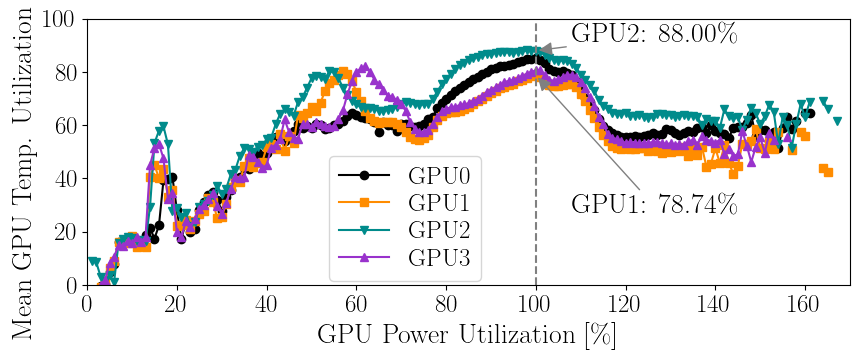

48

In [14]:
# 10 min runtime

# supress warnings that leak path/user data
import warnings
warnings.filterwarnings("ignore")

min_utilization = 0.0
df_prom_node_data_extended_4 = df_prom_node_data_extended_3.filter((col('nvidia_gpu_power_usage_milliwatts_0_ratio') >= min_utilization) & (col('nvidia_gpu_power_usage_milliwatts_1_ratio') >= min_utilization) & (col('nvidia_gpu_power_usage_milliwatts_2_ratio') >= min_utilization) & (col('nvidia_gpu_power_usage_milliwatts_3_ratio') >= min_utilization))
plot_gpu_power_temp(df_prom_node_data_extended_4, 'plots/section_4/gpu_power_temp')

# count how many different nodes with 4 GPUs are in the dataset
df_prom_node_data_extended_4.select('node').distinct().count()

Check if results are different, if all GPUs are on a high power level at the same time.

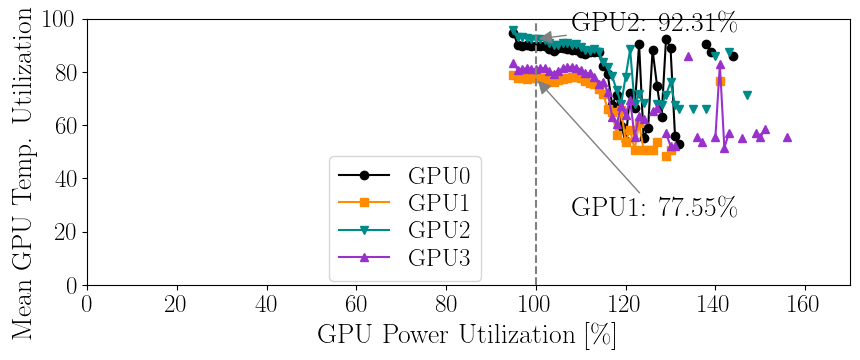

In [15]:
# 5 min runtime

min_utilization = 0.95
df_prom_node_data_extended_4 = df_prom_node_data_extended_3.filter((col('nvidia_gpu_power_usage_milliwatts_0_ratio') >= min_utilization) & (col('nvidia_gpu_power_usage_milliwatts_1_ratio') >= min_utilization) & (col('nvidia_gpu_power_usage_milliwatts_2_ratio') >= min_utilization) & (col('nvidia_gpu_power_usage_milliwatts_3_ratio') >= min_utilization))
plot_gpu_power_temp(df_prom_node_data_extended_4, 'plots/section_4/gpu_power_temp_over_95_util')

Result: The overall trend and ordering of GPUs in the plot remains the same.